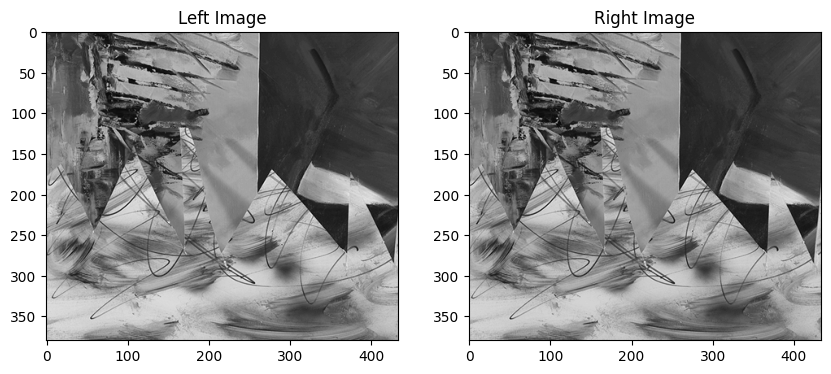

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load stereo images
left_image = cv2.imread('/content/im0.ppm', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('/content/im1.ppm', cv2.IMREAD_GRAYSCALE)

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Left Image")
plt.imshow(left_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Right Image")
plt.imshow(right_image, cmap='gray')
plt.show()


In [ ]:
def calculate_sad(left_image, right_image, template_size, search_window):
    rows, cols = left_image.shape
    disparity_map = np.zeros((rows, cols))

    half_template = template_size // 2
    half_search = search_window // 2

    for y in range(half_template, rows - half_template):
        for x in range(half_template, cols - half_template):
            template = left_image[y - half_template: y + half_template + 1,
                                  x - half_template: x + half_template + 1]

            min_sad = float('inf')
            best_offset = 0

            for offset in range(-half_search, half_search + 1):
                x_offset = x + offset
                if x_offset - half_template < 0 or x_offset + half_template >= cols:
                    continue

                window = right_image[y - half_template: y + half_template + 1,
                                     x_offset - half_template: x_offset + half_template + 1]

                sad = np.sum(np.abs(template - window))
                if sad < min_sad:
                    min_sad = sad
                    best_offset = offset

            disparity_map[y, x] = best_offset

    return disparity_map


In [ ]:
def calculate_ssd(left_image, right_image, template_size, search_window):
    rows, cols = left_image.shape
    disparity_map = np.zeros((rows, cols))

    half_template = template_size // 2
    half_search = search_window // 2

    for y in range(half_template, rows - half_template):
        for x in range(half_template, cols - half_template):
            template = left_image[y - half_template: y + half_template + 1,
                                  x - half_template: x + half_template + 1]

            min_ssd = float('inf')
            best_offset = 0

            for offset in range(-half_search, half_search + 1):
                x_offset = x + offset
                if x_offset - half_template < 0 or x_offset + half_template >= cols:
                    continue

                window = right_image[y - half_template: y + half_template + 1,
                                     x_offset - half_template: x_offset + half_template + 1]

                ssd = np.sum((template - window) ** 2)
                if ssd < min_ssd:
                    min_ssd = ssd
                    best_offset = offset

            disparity_map[y, x] = best_offset

    return disparity_map


In [ ]:
def calculate_ncc(left_image, right_image, template_size, search_window):
    rows, cols = left_image.shape
    disparity_map = np.zeros((rows, cols))

    half_template = template_size // 2
    half_search = search_window // 2

    for y in range(half_template, rows - half_template):
        for x in range(half_template, cols - half_template):
            template = left_image[y - half_template: y + half_template + 1,
                                  x - half_template: x + half_template + 1]
            template_mean = np.mean(template)
            template_std = np.std(template)

            max_ncc = -1
            best_offset = 0

            for offset in range(-half_search, half_search + 1):
                x_offset = x + offset
                if x_offset - half_template < 0 or x_offset + half_template >= cols:
                    continue

                window = right_image[y - half_template: y + half_template + 1,
                                     x_offset - half_template: x_offset + half_template + 1]
                window_mean = np.mean(window)
                window_std = np.std(window)

                if template_std > 0 and window_std > 0:
                    ncc = np.sum((template - template_mean) * (window - window_mean)) / (
                        template_std * window_std * template.size)
                else:
                    ncc = 0

                if ncc > max_ncc:
                    max_ncc = ncc
                    best_offset = offset

            disparity_map[y, x] = best_offset

    return disparity_map


In [ ]:
def region_based_analysis(left_image, right_image, template_size, search_window, method='SAD'):
    if method == 'SAD':
        return calculate_sad(left_image, right_image, template_size, search_window)
    elif method == 'SSD':
        return calculate_ssd(left_image, right_image, template_size, search_window)
    elif method == 'NCC':
        return calculate_ncc(left_image, right_image, template_size, search_window)
    else:
        raise ValueError("Invalid method! Choose from 'SAD', 'SSD', or 'NCC'.")


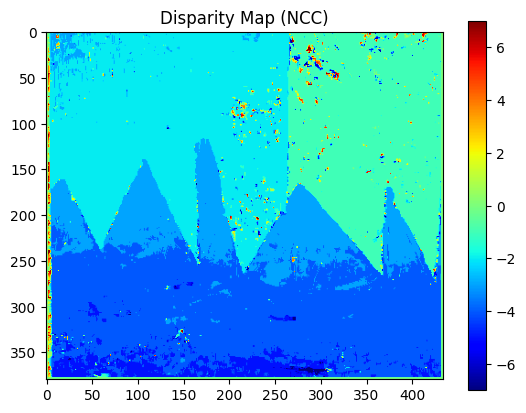

In [ ]:
# User input for parameters
template_size = 5
search_window = 15
method = 'NCC'  # Change to 'SAD', 'SSD', or 'NCC'

# Perform region-based analysis
disparity_map = region_based_analysis(left_image, right_image, template_size, search_window, method)

# Display disparity map
plt.imshow(disparity_map, cmap='jet')
plt.colorbar()
plt.title(f"Disparity Map ({method})")
plt.show()


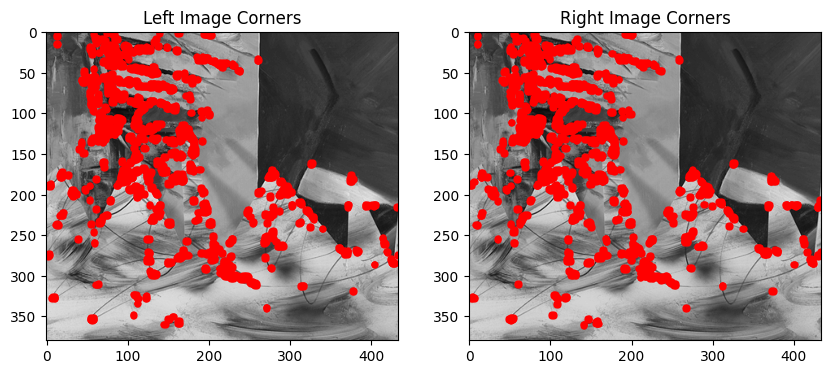

In [ ]:
def detect_features(image, block_size=2, ksize=3, k=0.04, threshold=0.01):

    # Harris Corner Detection
    harris_response = cv2.cornerHarris(image, block_size, ksize, k)

    # Normalize the response
    harris_response = cv2.dilate(harris_response, None)
    corners = np.argwhere(harris_response > threshold * harris_response.max())

    return corners

# Detect corners in the left and right images
left_corners = detect_features(left_image)
right_corners = detect_features(right_image)

# Visualize corners
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Left Image Corners")
plt.imshow(left_image, cmap='gray')
plt.scatter(left_corners[:, 1], left_corners[:, 0], s=10, c='red', marker='o')

plt.subplot(1, 2, 2)
plt.title("Right Image Corners")
plt.imshow(right_image, cmap='gray')
plt.scatter(right_corners[:, 1], right_corners[:, 0], s=10, c='red', marker='o')

plt.show()


In [ ]:
def match_features(left_image, right_image, left_corners, right_corners, template_size, method='SAD'):

    half_template = template_size // 2
    matches = []

    for lx, ly in left_corners:
        if lx - half_template < 0 or lx + half_template >= left_image.shape[0] or \
           ly - half_template < 0 or ly + half_template >= left_image.shape[1]:
            continue

        # Extract the template from the left image
        template = left_image[lx - half_template: lx + half_template + 1,
                              ly - half_template: ly + half_template + 1]

        best_score = float('inf') if method != 'NCC' else float('-inf')
        best_match = None

        for rx, ry in right_corners:
            if rx - half_template < 0 or rx + half_template >= right_image.shape[0] or \
               ry - half_template < 0 or ry + half_template >= right_image.shape[1]:
                continue

            # Extract the window from the right image
            window = right_image[rx - half_template: rx + half_template + 1,
                                 ry - half_template: ry + half_template + 1]

            if method == 'SAD':
                score = np.sum(np.abs(template - window))
                if score < best_score:
                    best_score = score
                    best_match = (rx, ry)

            elif method == 'SSD':
                score = np.sum((template - window) ** 2)
                if score < best_score:
                    best_score = score
                    best_match = (rx, ry)

            elif method == 'NCC':
                template_mean, window_mean = np.mean(template), np.mean(window)
                template_std, window_std = np.std(template), np.std(window)

                if template_std == 0 or window_std == 0:
                    continue

                score = np.sum((template - template_mean) * (window - window_mean)) / (template_std * window_std * template.size)
                if score > best_score:  # Maximize NCC
                    best_score = score
                    best_match = (rx, ry)

        if best_match is not None:
            matches.append(((lx, ly), best_match))

    return matches

# Match features using SAD (or switch to SSD/NCC)
template_size = 5  # Example size
method = 'SAD'  # Choose between 'SAD', 'SSD', 'NCC'
matches = match_features(left_image, right_image, left_corners, right_corners, template_size, method)


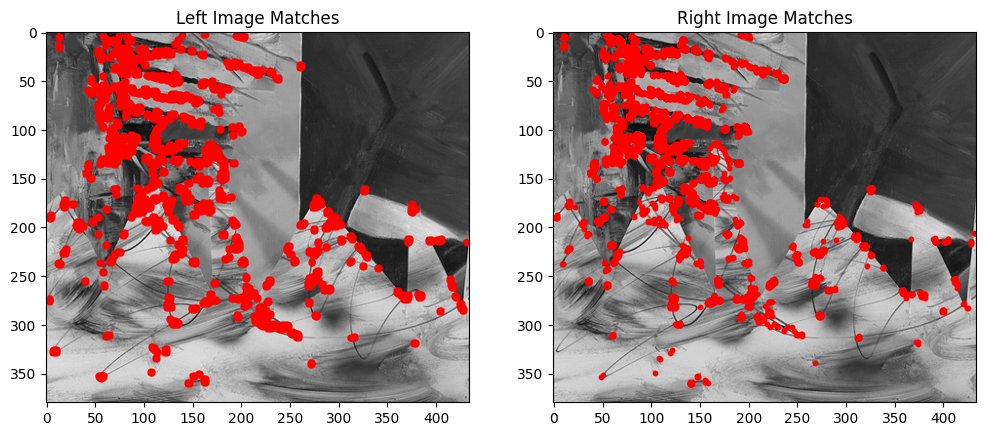

In [ ]:
def visualize_matches(left_image, right_image, matches):

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(left_image, cmap='gray')
    ax[0].set_title("Left Image Matches")
    ax[1].imshow(right_image, cmap='gray')
    ax[1].set_title("Right Image Matches")

    for (lx, ly), (rx, ry) in matches:
        ax[0].scatter(ly, lx, s=10, c='red')
        ax[1].scatter(ry, rx, s=10, c='red')

    plt.show()

# Visualize feature matches
visualize_matches(left_image, right_image, matches)


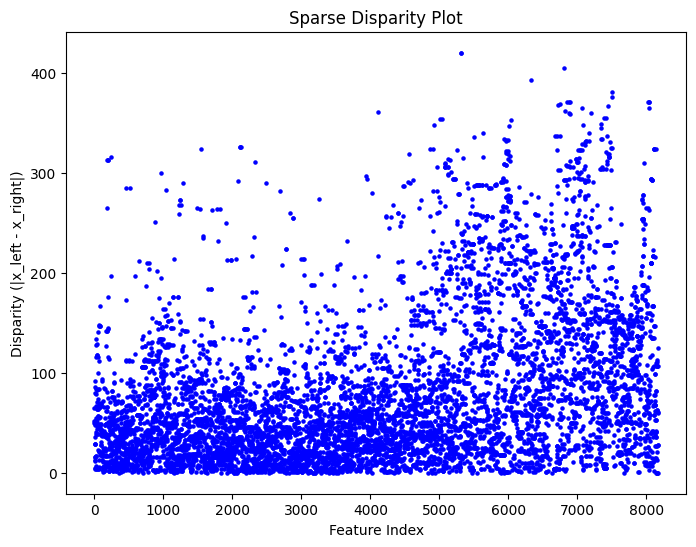

In [ ]:
def sparse_disparity_plot(matches):

    disparities = [abs(ly - ry) for (lx, ly), (rx, ry) in matches]

    # Plot sparse disparity
    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(disparities)), disparities, c='blue', s=5)
    plt.title("Sparse Disparity Plot")
    plt.xlabel("Feature Index")
    plt.ylabel("Disparity (|x_left - x_right|)")
    plt.show()

# Visualize sparse disparity
sparse_disparity_plot(matches)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_gaussian_pyramid(img, levels):

    pyramid = [img]
    for i in range(1, levels):
        img = cv2.pyrDown(img)
        pyramid.append(img)
    return pyramid

def region_based_matching_all_metrics(img_left, img_right, template_size, window_size, metric='NCC'):

    height, width = img_left.shape
    disparity_map = np.zeros((height, width), dtype=np.float32)

    half_template = template_size[0] // 2
    half_window = window_size[0] // 2

    for y in range(half_template, height - half_template):
        for x in range(half_template, width - half_template):
            # Extract template from left image
            template = img_left[y - half_template:y + half_template + 1,
                                x - half_template:x + half_template + 1]

            best_score = float('inf') if metric != 'NCC' else float('-inf')
            best_disparity = 0

            # Search within the window in the right image
            for dx in range(-half_window, half_window + 1):
                x_right = x + dx
                if x_right - half_template < 0 or x_right + half_template >= width:
                    continue

                # Extract window from right image
                window = img_right[y - half_template:y + half_template + 1,
                                   x_right - half_template:x_right + half_template + 1]

                # Compute matching metric
                if metric == 'SAD':
                    score = np.sum(np.abs(template - window))
                    if score < best_score:
                        best_score = score
                        best_disparity = dx
                elif metric == 'SSD':
                    score = np.sum((template - window) ** 2)
                    if score < best_score:
                        best_score = score
                        best_disparity = dx
                elif metric == 'NCC':
                    norm_template = (template - np.mean(template)) / (np.std(template) + 1e-5)
                    norm_window = (window - np.mean(window)) / (np.std(window) + 1e-5)
                    score = np.sum(norm_template * norm_window)
                    if score > best_score:
                        best_score = score
                        best_disparity = dx

            # Assign disparity to the disparity map
            disparity_map[y, x] = abs(best_disparity)

    return disparity_map

def multi_resolution_matching(img_left, img_right, levels=3, template_size=(7, 7), window_size=(21, 21), metric='NCC'):

    # Create Gaussian pyramids for both images
    pyramid_left = create_gaussian_pyramid(img_left, levels)
    pyramid_right = create_gaussian_pyramid(img_right, levels)

    # Initialize disparity map at the coarsest level
    disparity_map = None

    for level in reversed(range(levels)):
        print(f"Processing level {level}...")
        img_left_resized = pyramid_left[level]
        img_right_resized = pyramid_right[level]

        # Perform disparity matching
        if disparity_map is None:
            disparity_map = region_based_matching_all_metrics(
                img_left_resized, img_right_resized, template_size, window_size, metric=metric
            )
        else:
            # Upsample disparity map to the current level
            disparity_map = cv2.pyrUp(disparity_map)
            disparity_map = cv2.resize(disparity_map, (img_left_resized.shape[1], img_left_resized.shape[0]))

            # Refine disparity map
            refined_disparity = region_based_matching_all_metrics(
                img_left_resized, img_right_resized, template_size=(5, 5), window_size=(31, 31), metric=metric
            )
            disparity_map = 0.5 * disparity_map + 0.5 * refined_disparity

    return disparity_map


Performing multi-resolution matching...
Processing level 2...
Processing level 1...
Processing level 0...


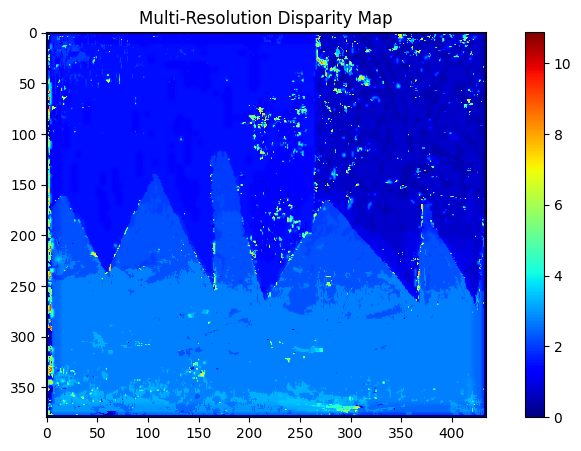

In [ ]:
def main_multi_resolution():
    # Load stereo images
    img_left = cv2.imread('/content/im0.ppm', cv2.IMREAD_GRAYSCALE)
    img_right = cv2.imread('/content/im1.ppm', cv2.IMREAD_GRAYSCALE)

    if img_left is None or img_right is None:
        print("Error: Could not load images.")
        return

    # Perform multi-resolution matching
    print("Performing multi-resolution matching...")
    disparity_map = multi_resolution_matching(
        img_left, img_right, levels=3, template_size=(7, 7), window_size=(21, 21), metric='NCC'
    )

    # Visualize the final disparity map
    plt.figure(figsize=(10, 5))
    plt.imshow(disparity_map, cmap='jet')
    plt.colorbar()
    plt.title("Multi-Resolution Disparity Map")
    plt.show()

if __name__ == "__main__":
    main_multi_resolution()


In [ ]:
def validate_disparity(left_disparity, right_disparity):

    height, width = left_disparity.shape
    validated_disparity = np.copy(left_disparity)

    for y in range(height):
        for x in range(width):
            d_left = left_disparity[y, x]
            if x - d_left >= 0:  # Ensure valid coordinates
                d_right = right_disparity[y, int(x - d_left)]
                if abs(d_left - d_right) > 1:  # Threshold for disparity mismatch
                    validated_disparity[y, x] = 0  # Mark invalid pixels as zero

    return validated_disparity


In [ ]:
def fill_disparity_gaps(disparity_map, window_size=5):

    filled_disparity = np.copy(disparity_map)
    height, width = disparity_map.shape
    half_window = window_size // 2

    for y in range(height):
        for x in range(width):
            if disparity_map[y, x] == 0:  # Gap detected
                # Collect valid neighbors
                neighbors = []
                for wy in range(-half_window, half_window + 1):
                    for wx in range(-half_window, half_window + 1):
                        ny, nx = y + wy, x + wx
                        if 0 <= ny < height and 0 <= nx < width and disparity_map[ny, nx] > 0:
                            neighbors.append(disparity_map[ny, nx])
                # Fill gap with the average of valid neighbors
                if neighbors:
                    filled_disparity[y, x] = np.mean(neighbors)

    return filled_disparity


Processing level 2...
Processing level 1...
Processing level 0...
Processing level 2...
Processing level 1...
Processing level 0...


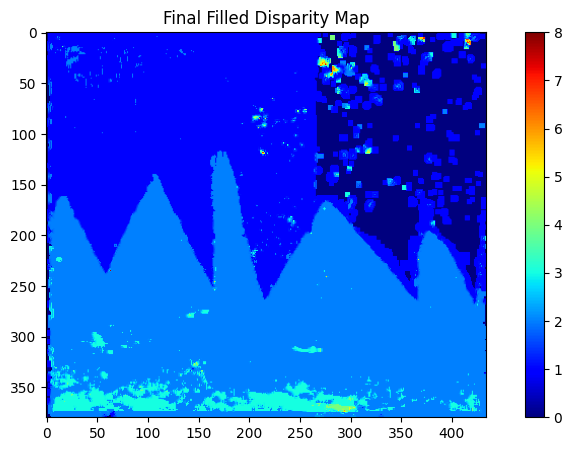

In [ ]:
# Example workflow
if __name__ == "__main__":
    # Load stereo images
    img_left = cv2.imread('/content/im0.ppm', cv2.IMREAD_GRAYSCALE)
    img_right = cv2.imread('/content/im1.ppm', cv2.IMREAD_GRAYSCALE)

    # Compute left-to-right and right-to-left disparity maps
    left_disparity_map = multi_resolution_matching(
        img_left, img_right, levels=3, template_size=(7, 7), window_size=(21, 21), metric='NCC'
    )
    right_disparity_map = multi_resolution_matching(
        img_right, img_left, levels=3, template_size=(7, 7), window_size=(21, 21), metric='NCC'
    )

    # Validate left-to-right disparity map
    validated_disparity_map = validate_disparity(left_disparity_map, right_disparity_map)

    # Fill gaps in the validated disparity map
    filled_disparity_map = fill_disparity_gaps(validated_disparity_map, window_size=5)

    # Visualize the final filled disparity map
    plt.figure(figsize=(10, 5))
    plt.imshow(filled_disparity_map, cmap='jet')
    plt.colorbar()
    plt.title("Final Filled Disparity Map")
    plt.show()
